In [15]:
from spiking import SpikingNNModel, LIF
from callbacks import VoltageTracking

import time
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.8.2


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'ticks')

In [17]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
EXTRA_SIZE = 24
 
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=EXTRA_SIZE)  # fontsize of the figure title

# Define custom model class

In [18]:
class CustomSpikingNNModel(SpikingNNModel):
    def __init__(self, step=50, **kwargs):
        super().__init__(**kwargs)
        self.num_step = tf.Variable(0.)
        self.step = step

    def update_kernel_condition(self):
        self.num_step.assign_add(1.0, read_value=False)
        return self.num_step % self.step == 0

# Define LIF Layer and SpikingNN Model Parameters

### Note: Update dt to 0.0001 to get model to learn; notebook will take approximately 2.5 hours to run

In [19]:
N = 5000
T = 5
dt = 0.01 # Update to 0.0001 
tau_ref = 0.002   
tau_mem = 0.01 
v_reset = -65
v_peak = -40
tau_decay = 0.02
tau_rise = 0.002
tau_syn = tau_decay
alpha = dt
Q = 10
G = 0.04
I_bias = -40

T_on = 0.5
T_delay = 0.05
p_recurr = 1.0

g = 1.0
print('Number of timesteps: ', T/dt)

Number of timesteps:  500.0


In [20]:
def get_input_target(T, dt, T_on, T_delay):
    t_step_start = int(np.random.uniform(0, (T - 2 * T_on - T_delay) / dt))

    input = np.zeros((round(T / dt), 1)).astype(np.float32)
    input[t_step_start:t_step_start + round(T_on / dt)] = 1

    target = np.zeros(input.shape).astype(np.float32)
    target[t_step_start + round((T_delay + T_on) / dt):t_step_start + round((T_delay + 2 * T_on) / dt)] = 1
    assert not np.all(target == input)

    return input, target

In [21]:
np.random.seed(0)
input_list = []
target_list = []

for i in range(10):
    input, target = get_input_target(T=T, dt=dt, T_on=T_on, T_delay=T_delay)
    input_list.append(tf.expand_dims(input, axis=0))
    target_list.append(tf.expand_dims(target, axis=0))

input = tf.concat(input_list, axis=0)
target = tf.concat(target_list, axis=0)
m = target.shape[-1]

assert input.shape == target.shape
print('Target shape: ', target.shape)
print('Target output dimension: ,', m)
print(np.mean(target))

Target shape:  (10, 500, 1)
Target output dimension: , 1
0.1


# Visualize randomly generated inputs

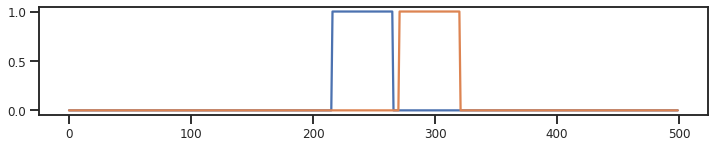

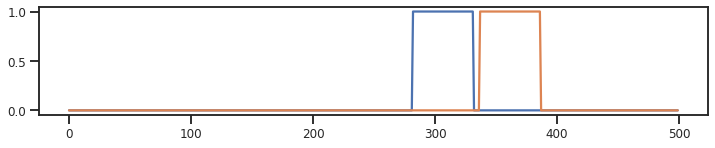

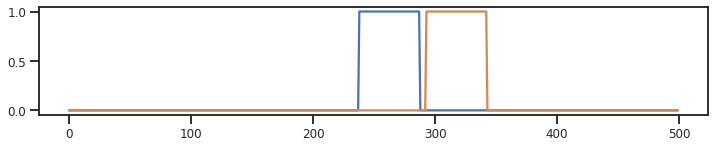

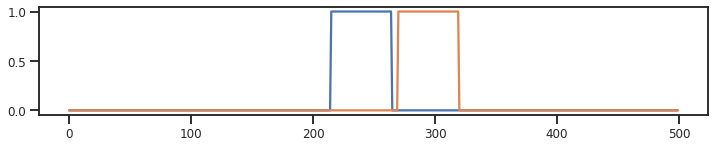

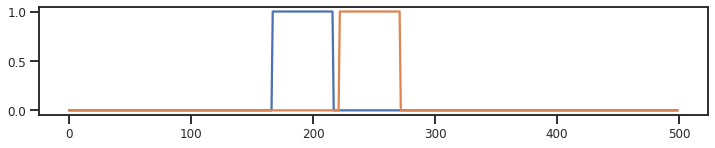

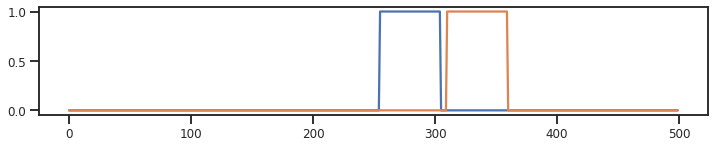

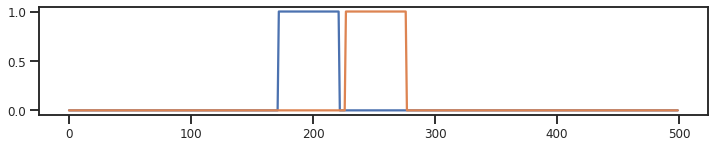

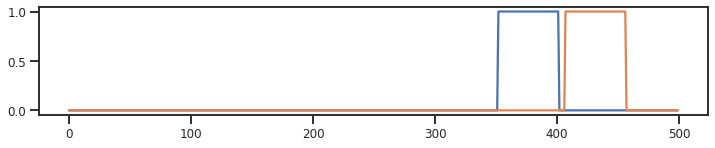

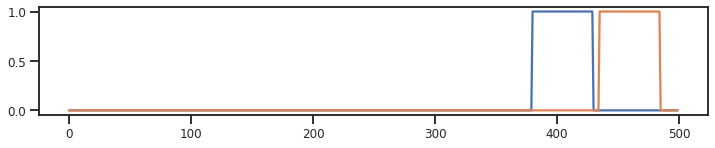

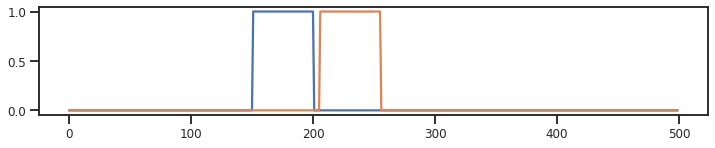

In [22]:
for i in range(input.shape[0]):
    plt.figure(figsize = (12,2))
    plt.plot(input[i])
    plt.plot(target[i])

# Define Spiking layer and model objects

In [23]:
%%time 
LIF_layer = LIF(units=N, 
                output_size=m,
                dt=dt,
                tau_decay=tau_decay,
                tau_rise=tau_rise, 
                tau_syn=tau_syn, 
                tau_ref=tau_ref,
                tau_mem=tau_mem,
                v_peak=v_peak, 
                v_reset=v_reset, 
                I_bias=I_bias,
                G=G, 
                Q=Q, 
                p_recurr=p_recurr,
                g=g,
                seed=0)
spikingmodel = CustomSpikingNNModel(force_layer=LIF_layer, 
                                    alpha_P=alpha,
                                    step=50)
spikingmodel.compile(metrics=["mae"])

CPU times: user 13.9 ms, sys: 2 µs, total: 13.9 ms
Wall time: 13 ms


# Fit the model

### Note: Will take approximately 2.5 hours with appropriate dt (0.0001)

In [24]:
%%time
history = spikingmodel.fit(x=input, y=target, epochs=5) 

Epoch 1/5
5000/5000 [==============================] - 99s 19ms/step - mae: 374.2599
Epoch 2/5
5000/5000 [==============================] - 98s 20ms/step - mae: 4099.7734
Epoch 3/5
5000/5000 [==============================] - 97s 19ms/step - mae: 5548.7202
Epoch 4/5
5000/5000 [==============================] - 99s 20ms/step - mae: 6339.1509
Epoch 5/5
5000/5000 [==============================] - 98s 20ms/step - mae: 5824.8853
CPU times: user 13min 24s, sys: 20.5 s, total: 13min 44s
Wall time: 8min 11s


In [25]:
%%time
np.random.seed(123)
 
test_input, test_target = get_input_target(T=T, dt=dt, T_on=T_on, T_delay=T_delay)
voltage_tracking = VoltageTracking(timesteps=test_input.shape[0], num_neurons=5, voltage_state_idx=1)
prediction = spikingmodel.predict(test_input, callbacks=[voltage_tracking])

CPU times: user 16 s, sys: 332 ms, total: 16.4 s
Wall time: 9.13 s


# Check result and add spikes to voltages

In [26]:
if dt <= 0.001:
    assert np.max(spikingmodel.force_layer.states[1]) <= v_peak
    assert np.min(spikingmodel.force_layer.states[1]) >= v_reset
    assert np.min(voltage_tracking.tracking_arr) >= v_reset
    assert np.max(voltage_tracking.tracking_arr) <= v_peak

In [27]:
x = np.arange(0, test_input.shape[0]) * dt
voltage_plot = np.copy(voltage_tracking.tracking_arr)

mask = (voltage_tracking.tracking_arr == v_reset)
mask = mask[:-1] < mask[1:]
mask = np.concatenate([np.zeros((1, mask.shape[1])) != 0, mask], axis=0)

voltage_plot[mask] = 30

# Create plots

[]

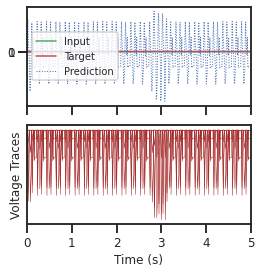

In [28]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(4,4))

ax0.plot(x, test_input, color='g', label='Input', linewidth=1.5)
ax0.plot(x, test_target, color='r', label='Target', linewidth=1.5)
ax0.plot(x, prediction, color='b',label='Prediction', linewidth=1, linestyle=":")
ax0.legend(loc='center left')
ax0.set_yticks([0, 1])

for i in range(5):
    ax1.plot(x, voltage_plot[:, i] + i * 100, color='brown', linewidth=0.5)
 
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage Traces')
ax1.set_xlim(left=min(x), right=max(x) + dt)
ax1.set_yticks([])